In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch
import torchvision
from torchvision import datasets
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import pandas as pd
import random
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
from tqdm import tqdm
import wandb
import scipy.ndimage
from torch.utils.data import DataLoader, TensorDataset, Dataset

# Create sequences

In [8]:
def apply_square(img, square_size):
    img = np.array(img)
    img[:square_size, :square_size] = 255
    return img

In [9]:
def apply_noise(img, bit_flip_ratio):
    img = np.array(img)
    mask = np.random.random(size=(28, 28)) < bit_flip_ratio
    img[mask] = 255 - img[mask]
    return img

In [10]:
def get_rotations(img, rotation_steps):
    # yield image for each rotation step
    for rot in rotation_steps:
        img = scipy.ndimage.rotate(img, rot, reshape=False)
        yield img

In [11]:
def get_squares_size_increasing(square_count, square_max, square_min):
    step_size = (square_max - square_min) // (square_count - 1)
    sizes = [square_min + step_size * i for i in range(square_count)]
    return [int(size) for size in sizes]

In [12]:
def get_squares_size(square_count, middle_size):
    sizes = []

    if square_count % 2 == 0:  # If square_count is even
        step_size = (middle_size - 2) // (square_count // 2 - 1)

        for i in range(square_count):
            if i < square_count // 2:
                size = 2 + step_size * i
            else:
                size = 2 + step_size * (square_count - 1 - i)
            sizes.append(size)
    else:  # If square_count is odd
        step_size = (middle_size - 2) // (square_count // 2)

        for i in range(square_count):
            if i <= square_count // 2:
                size = 2 + step_size * i
            else:
                size = middle_size - step_size * (i - square_count // 2)
            sizes.append(size)

    return sizes




In [13]:
def get_squares_size(square_count, middle_size):
    sizes = []

    if square_count % 2 == 0:  # If square_count is even
        step_size = (middle_size - 3) / ((square_count-1) // 2)
        j = 1
        for i in range(square_count):
            if i < square_count // 2:
                size = 3 + step_size * i
            elif i == square_count / 2:
                size = middle_size
            else:

                size = middle_size - step_size * j
                j += 1
            sizes.append(int(size))
    else:  # If square_count is odd
        step_size = (middle_size - 3) / ((square_count) // 2)
        j = 1
        for i in range(square_count):
            if i <= square_count // 2:
                size = 3 + step_size * i
            else:
                size = middle_size - step_size * j
                j += 1
            sizes.append(int(size))

    return sizes




In [41]:
def get_angles(seq_len, max_angle, std_noise):
    angles = np.zeros(seq_len)
    noise = np.random.normal(scale = std_noise, size=seq_len)
    if max_angle == "random": 
        #rot_angle = random.randrange(10, 91, 10)
        rot_angle = random.choice([30, 45, 60, 75, 90])
    else: 
        rot_angle = max_angle
    if seq_len > 1:
        for i in range(seq_len):
            #angles[i] = (max_angle / (seq_len - 1)) * i
            angles[i] = rot_angle
    
    return angles + noise, rot_angle

In [17]:
def binarize(img):
    return (img > 127).astype(int)

def normalize(img): 
    img = (img) / 255
    return img


In [34]:
def heal_image(img, seq_len, square_count_min, square_count_max, square_size, noise_ratio, max_angle, std_noise, square_min, square_max):
    square_count = random.randint(square_count_min, min(seq_len, square_count_max))
    squares_begin = np.random.randint(0, seq_len - square_count + 1)
    #squares_begin = seq_len - square_count
    squares_end = squares_begin + square_count
    square_label = 0

    rotations = []
    #rotation_steps = np.random.normal(size=seq_len, scale=max_angle)
    rotation_steps, rot_angle = get_angles(seq_len=seq_len, max_angle=max_angle, std_noise=std_noise)
    random_number = random.uniform(0,1)
    if square_min == square_max:
      square_sizes = np.full(square_count, square_min)
    else:
      square_sizes = get_squares_size(square_count, square_max)
    idx_square = 0
    for idx, rotation in enumerate(get_rotations(img, rotation_steps)):
        if random_number < 1:
          if squares_end == seq_len:
            square_label = 1
          if idx >= squares_begin and idx < squares_end:
              square_size = square_sizes[idx_square]
              rotation = apply_square(rotation, square_size)
              idx_square += 1

        # Don't add noise for now
        #if idx < len(rotation_steps)-1:
          #noisy_img = apply_noise(rotation, noise_ratio)
        #else:
          #noisy_img = rotation
        #binarized_img = binarize(noisy_img)
        #rotations.append(binarized_img)
        norm_img = normalize(rotation)

        rotations.append(norm_img)

    return rotations, rot_angle, square_label, square_count

### Class HealingMNIST

In [35]:
class HealingMNIST():

    def __init__(self, min_seq_len=1, max_seq_len=5, square_count_min=3, square_count_max=8, square_size=5, noise_ratio=0.15, digits=range(10), max_angle=180, std_noise=1, square_min=3, square_max=8):
        """Instantiate HealingMNIST() data class

        Args:
            min_seq_len (int, optional): Minimum length for each sequence of digits. Defaults to 1.
            max_seq_len (int, optional): Maximal length for sequence of digits. Defaults to 5.
            square_count (int, optional): Maximal number of squares in a sequence. Defaults to 3.
            square_size (int, optional): Square size. Defaults to 5.
            noise_ratio (float, optional): Injected noise (unused for now). Defaults to 0.15.
            digits (_type_, optional): Digits to use from the dataset. Defaults to range(10).
            max_angle (int, optional): Max rotation. Defaults to 180.
        """

        
        trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                              download=True)
        testset = torchvision.datasets.MNIST(root='./data', train=False,
                                             download=True)
        x_train = trainset.data
        y_train = trainset.targets
        x_test = testset.data
        y_test = testset.targets
        mnist_train = [(img, label) for img, label in zip(
            x_train, y_train) if label in digits]
        mnist_test = [(img, label)
                      for img, label in zip(x_test, y_test) if label in digits]
        
        """
        mnist_train = [(img, label) for img, label in zip(mnist.train_images(), mnist.train_labels()) if label in digits]
        mnist_test = [(img,label) for img, label in zip(mnist.test_images(), mnist.test_labels()) if label in digits]
        """

        train_images = []
        test_images = []
        train_rotations = []
        test_rotations = []
        train_labels = []
        test_labels = []
        train_squares = []
        test_squares = []
        train_square_counts = []
        test_square_counts = []
        train_seq_len = []
        test_seq_len = []


        for index, (img, label) in enumerate(mnist_train):
            # random sequence length
            seq_len_rand = random.choice(range(min_seq_len, max_seq_len + 1))
            #adapted_square_count = random.choice(
                #range(0, min(seq_len_rand, square_count)))
            #adapted_square_count = square_count+1
            

            train_img, train_rot, train_square, train_square_count = heal_image(
                img, seq_len_rand, square_count_min,square_count_max, square_size, noise_ratio, max_angle, std_noise,
                square_min, square_max)
            train_images.append(train_img)
            train_rotations.append(train_rot)
            train_labels.append(label)
            train_squares.append(train_square)
            train_square_counts.append(train_square_count)
            train_seq_len.append(seq_len_rand)

        for index, (img, label) in enumerate(mnist_test):
            # random sequence length
            seq_len_rand = random.choice(range(min_seq_len, max_seq_len + 1))
            #adapted_square_count = square_count+1
            #adapted_square_count = random.choice(
                #range(0, min(seq_len_rand, square_count)))
            test_img, test_rot, test_square, test_square_count = heal_image(
                img, seq_len_rand, square_count_min, square_count_max, square_size, noise_ratio, max_angle, std_noise,
                square_min, square_max)
            test_images.append(test_img)
            test_rotations.append(test_rot)
            test_labels.append(label)
            test_squares.append(test_square)
            test_square_counts.append(test_square_count)
            test_seq_len.append(seq_len_rand)

        self.train_images = np.array(train_images, dtype=object)
        self.test_images = np.array(test_images, dtype=object)
        self.train_rotations = np.array(train_rotations)
        self.test_rotations = np.array(test_rotations)
        self.train_labels = np.array(train_labels)
        self.test_labels = np.array(test_labels)
        self.train_squares = np.array(train_squares)
        self.test_squares = np.array(test_squares)
        self.train_square_counts = np.array(train_square_counts)
        self.test_square_counts = np.array(test_square_counts)
        self.train_seq_len = np.array(train_seq_len)
        self.test_seq_len = np.array(test_seq_len)

# Create embeddings

In [36]:
d = HealingMNIST(min_seq_len = 3, max_seq_len=6, square_count_min=3, square_count_max = 6, max_angle="random", std_noise = 1, square_min = 3, square_max = 8)

6150


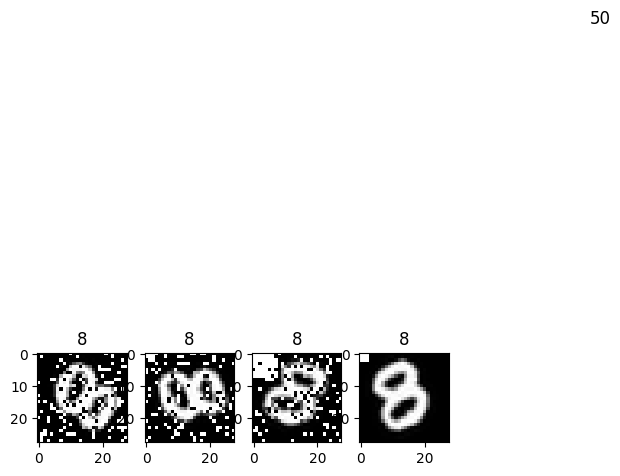

In [38]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(15, 8))

j = 1
index = random.choice(range(1, len(d.test_images)))
print(index)
fig.suptitle(d.test_rotations[index])
for i, image in enumerate(d.test_images[index]):
    fig.add_subplot(j, 11, i + 1)
    plt.imshow(np.array(image).astype(float), cmap="gist_gray")
    plt.title(d.test_labels[index])

## Convert sequence data into tensor dataset

In [39]:
d = []

In [24]:
from torch.nn.utils.rnn import pad_sequence
def get_data_rand_seq_len(min_seq_len, max_seq_len, square_count_min, square_count_max, max_angle, std_noise, square_min, square_max, encoder_pretrained, train_file, test_file):

  d = HealingMNIST(min_seq_len=min_seq_len, max_seq_len=max_seq_len, square_count_min=square_count_min, square_count_max= square_count_max, max_angle=max_angle, std_noise=std_noise, square_min=square_min, square_max = square_max)
  seq_len = max_seq_len-1

  ## Training data
  X_seq_train = []
  for seq in d.train_images: 
      X_seq_train.append(torch.tensor(seq[:-1], dtype=torch.float32).reshape(-1, 1, 28, 28))
  #X_seq_train = torch.stack(X_seq_train)
  
  X_target_train = []
  for seq in d.train_images: 
      X_target_train.append(torch.tensor(seq[-1], dtype=torch.float32))
  X_target_train = torch.stack(X_target_train).reshape(-1,1,28,28)

  label_train = torch.tensor(d.train_labels, dtype=torch.long)
  square_train = torch.tensor(d.train_squares, dtype=torch.int)
  rot_train = torch.tensor(d.train_rotations, dtype=torch.int)
  square_count_train = torch.tensor(d.train_square_counts, dtype=torch.int)
  seq_train = torch.tensor(d.train_seq_len, dtype = torch.int)

  ## Test data

  X_seq_test = []
  for seq in d.test_images: 
      X_seq_test.append(torch.tensor(seq[:-1], dtype=torch.float32).reshape(-1, 1, 28, 28))
  
  
  X_target_test = []
  for seq in d.test_images: 
      X_target_test.append(torch.tensor(seq[-1], dtype=torch.float32))
  X_target_test = torch.stack(X_target_test).reshape(-1,1,28,28)

  label_test = torch.tensor(d.test_labels, dtype=torch.long)
  square_test = torch.tensor(d.test_squares, dtype=torch.int8)
  rot_test = torch.tensor(d.test_rotations, dtype=torch.int8)
  square_count_test = torch.tensor(d.test_square_counts, dtype=torch.int8)
  seq_test= torch.tensor(d.test_seq_len, dtype = torch.int8)

  d = []
  #Feature extraction from images in sequence
  encoder_pretrained.eval()

  ## Training data
  outputs = []

  # Feed each datapoint through the network and store the output
  for sequence in tqdm(X_seq_train):
      output = encoder_pretrained(sequence)
      outputs.append(output)
  X_seq_train = []
  X_trainset = pad_sequence(outputs, batch_first = True)

  ## Test data
  outputs = []

  # Feed each datapoint through the network and store the output
  for sequence in tqdm(X_seq_test):
      output = encoder_pretrained(sequence)
      outputs.append(output)
  X_seq_test = []
  X_testset = pad_sequence(outputs, batch_first = True)
  outputs = []

  ## Create tensor datasets
  dataset_train = TensorDataset(X_trainset, X_target_train, label_train, rot_train, square_train, square_count_train, seq_train)
  dataset_test = TensorDataset(X_testset, X_target_test, label_test, rot_test, square_test, square_count_test, seq_test)

  ## store at specified filename
  torch.save(dataset_train, train_file)
  torch.save(dataset_test, test_file)

  return dataset_train, dataset_test

In [ ]:
def get_data_const_seq_len(min_seq_len, max_seq_len, square_count_min, square_count_max, max_angle, std_noise, square_min, square_max, encoder_pretrained, train_file, test_file):

  d = HealingMNIST(min_seq_len=min_seq_len, max_seq_len=max_seq_len, square_count_min=square_count_min, square_count_max=square_count_max, max_angle=max_angle, std_noise=std_noise, square_min=square_min, square_max = square_max)
  seq_len = max_seq_len

  ## Training data
  X_seq_train = torch.tensor(d.train_images.astype(float), dtype=torch.float32).reshape(-1, seq_len, 1, 28, 28)
  X_target_train = torch.tensor(d.train_images.astype(float)[:,-1,:,:].reshape(-1,1,28,28))
  label_train = torch.tensor(d.train_labels, dtype=torch.long)
  square_train = torch.tensor(d.train_squares, dtype=torch.int)
  rot_train = torch.tensor(d.train_rotations, dtype=torch.int)
  square_count_train = torch.tensor(d.train_square_counts, dtype=torch.int)
  seq_train = torch.tensor(d.train_seq_len, dtype = torch.int)

  ## Test data
  X_seq_test = torch.tensor(d.test_images.astype(float), dtype=torch.float32).reshape(-1, seq_len, 1, 28, 28)
  X_target_test = torch.tensor(d.test_images.astype(float)[:,-1,:,:].reshape(-1,1,28,28))
  label_test = torch.tensor(d.test_labels, dtype=torch.long)
  square_test = torch.tensor(d.test_squares, dtype=torch.int8)
  rot_test = torch.tensor(d.test_rotations, dtype=torch.int8)
  square_count_test = torch.tensor(d.test_square_counts, dtype=torch.int8)
  seq_test= torch.tensor(d.test_seq_len, dtype = torch.int8)

  d = []
  #Feature extraction from images in sequence
  encoder_pretrained.eval()

  ## Training data
  outputs = []

  # Feed each datapoint through the network and store the output
  for sequence in tqdm(X_seq_train):
      output = encoder_pretrained(sequence)
      outputs.append(output)
  X_seq_train = []
  X_trainset = torch.stack(outputs)

  ## Test data
  outputs = []

  # Feed each datapoint through the network and store the output
  for sequence in tqdm(X_seq_test):
      output = encoder_pretrained(sequence)
      outputs.append(output)
  X_seq_test = []
  X_testset = torch.stack(outputs)
  outputs = []

  ## Create tensor datasets
  dataset_train = TensorDataset(X_trainset[:,:-1,:], X_target_train, label_train, rot_train, square_train, square_count_train, seq_train)
  dataset_test = TensorDataset(X_testset[:,:-1,:], X_target_test, label_test, rot_test, square_test, square_count_test, seq_test)

  ## store at specified filename
  torch.save(dataset_train, train_file)
  torch.save(dataset_test, test_file)

  return dataset_train, dataset_test





# Feature extraction from images

via encoder part of CNN --> extract features from spatially resolved image data via pre-implemented encoder part of convolutional autoencoder to get low-dimensional embedding

1) reload pre-trained encoder part
2) feed every sequence through encoder to get low-dimensional embedding of each sequence
3) store low-dimensional embedding of each sequence again in tensor dataset that can serve as input to LSTM

BONUS: it would be good to have another fully connected layer inbetween the embeddings as input and the LSTM to have variable size of embedding as well as fine-tuning the network. 

In [25]:
## Construction of encoder part
class Encoder_original(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            #nn.Dropout(p=0.2),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            #nn.Dropout(p=0.2),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
            #nn.Dropout(p=0.2)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            #nn.Dropout(p=0.5),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

In [26]:
encoder_pretrained = Encoder_original(encoded_space_dim=25,fc2_input_dim=128)

In [27]:
encoder_pretrained.load_state_dict(torch.load("encoder_25_normalized.pt"))
encoder_pretrained.eval()

Encoder_original(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=25, bias=True)
  )
)

# Create Sequence Data

In [42]:
train_file = "train_seq_data"
test_file = "test_seq_data"
seq_len = 6
trainset, testset = get_data_rand_seq_len(min_seq_len = 3, max_seq_len=6, square_count_min=3, square_count_max=6, max_angle="random", std_noise = 1, 
                                            square_min = 3, square_max = 8,
                                            encoder_pretrained=encoder_pretrained, train_file = train_file, test_file = test_file)

100%|██████████| 10000/10000 [00:07<00:00, 1273.82it/s]


In [ ]:
trainloader = DataLoader(dataset=trainset, batch_size=128, shuffle=False)
testloader = DataLoader(dataset=testset, batch_size=128, shuffle=False)
